In [1]:
!pip install keras


In [2]:
!pip install tensorflow

In [3]:
#https://analyticsindiamag.com/comprehensive-guide-to-learning-rate-algorithms-with-python-codes/
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2020)

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10


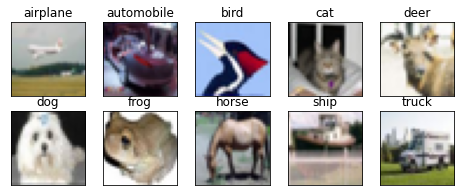

In [4]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


In [8]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [10]:
(trainX, trainy), (testX, testy) = cifar10.load_data()
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(trainX)
iterator = datagen.flow(trainX, trainy, batch_size=128)
batchX, batchy = iterator.next()
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())
min_pix,max_pix = batchX.min(), batchX.max()


(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [11]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy

In [22]:
#Now, build a CNN model with batch normalization and regularization function (for faster convergence) and bear in mind to use SGD optimizer
from keras import optimizers
model1 = Sequential()

model1.add(Convolution2D(32, 3, 3, kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))


model1.add(Convolution2D(32, 1, 1))
model1.add(Convolution2D(64, 3, 3, kernel_regularizer = regularizers.l2 (0.0001)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())


model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))
model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())
model1.add(Activation('softmax'))


sgd = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)


model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])






ValueError: ignored

In [23]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser


In [ ]:
#Let us go ahead and implement the LR finder algorithm from Keras.
from keras.callbacks import Callback

class LR_Finder(Callback):

     def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):

        super().__init__()

        self.start_lr = start_lr

        self.end_lr = end_lr

        self.step_size = step_size

        self.beta = beta

        self.lr_mult = (end_lr/start_lr)**(1/step_size)

        

    def on_train_begin(self, logs=None):

        self.best_loss = 1e9

        self.avg_loss = 0

        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []

        self.iteration = 0

        logs = logs or {}

        K.set_value(self.model.optimizer.lr, self.start_lr)

        

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}

        loss = logs.get('loss')

        self.iteration += 1

        

        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss

        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)

        if self.iteration>1 and smoothed_loss > self.best_loss * 4:

            self.model.stop_training = True

            return


        if smoothed_loss < self.best_loss or self.iteration==1:

            self.best_loss = smoothed_loss


        lr = self.start_lr * (self.lr_mult**self.iteration)
    

        self.losses.append(loss)

        self.smoothed_losses.append(smoothed_loss)

        self.lrs.append(lr)

        self.iterations.append(self.iteration)

        K.set_value(self.model.optimizer.lr, lr)  

    def plot_lr(self):

        plt.xlabel('Iterations')

        plt.ylabel('Learning rate')

        plt.plot(self.iterations, self.lrs)

    def plot(self, n_skip=1):

        plt.ylabel('Loss')

        plt.xlabel('Learning rate (log scale)')

        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])

        plt.xscale('log')

        

    def plot_smoothed_loss(self, n_skip=10):

        plt.ylabel('Smoothed Losses')

        plt.xlabel('Learning rate (log scale)')

        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])

        plt.xscale('log')


    def plot_loss(self):

        plt.ylabel('Losses')

        plt.xlabel('Iterations')

        plt.plot(self.iterations[10:], self.losses[10:])
It is time to put everything together. We will define our accuracy function and a function to plot the model graphically. 

def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])

    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])

    axs[0].set_title('Model Accuracy')

    axs[0].set_ylabel('Accuracy')

    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)

    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])

    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')

    axs[1].set_ylabel('Loss')

    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)

    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

def accuracy(test_x, test_y, model):

    result = model.predict(test_x)

    predicted_class = np.argmax(result, axis=1)

    true_class = np.argmax(test_y, axis=1)

    num_correct = np.sum(predicted_class == true_class) 

    accuracy = float(num_correct)/result.shape[0]

    return (accuracy * 100)


datagen = ImageDataGenerator(zoom_range=0.0, 

                             horizontal_flip=False, 

                             preprocessing_function=get_random_eraser(v_l=min_pix, v_h=max_pix, pixel_level=True))




lr_finder = LR_Finder(start_lr=1e-5, end_lr=1e-2, step_size=np.ceil(X_train.shape[0]/128))

start = time.time()

model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),

                                  samples_per_epoch = train_features.shape[0], nb_epoch = 100, 

                                  validation_data = (X_test, Y_test), verbose=0,

                                  callbacks=[lr_finder])

end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))




lr_finder.plot_lr()

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint

class CyclicLR(Callback):
  def __init__(self, min_lr, max_lr, stepsize=1000):

    super().__init__()

    self.min_lr = min_lr

    self.max_lr = max_lr

    self.currstep = 0

    self.stepsize = stepsize

  def on_train_batch_begin(self, batch, logs=None):

    currstep = self.currstep

    stepsize = self.stepsize

    min_lr   = self.min_lr

    max_lr   = self.max_lr


    dlr = (max_lr - min_lr) / stepsize


    if currstep < stepsize :

      dlr = dlr*currstep

    else:

      dlr = dlr*(2*stepsize - currstep)


    lr = min_lr + dlr

    K.set_value(self.model.optimizer.lr, lr)

    self.currstep += 1

  def on_train_batch_end(self, batch, logs=None):

    if self.currstep == 4000:

      self.currstep = 0


clr = CyclicLR(2e-4, 2e-2, 2000)

model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

def scheduler(epoch, lr):

  return round(1e-2/(1+0.1*epoch), 10)

start = time.time()


model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),

                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 

                                 validation_data = (X_test, Y_test), verbose=1,

                                 callbacks=[clr])

end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

plot_model_history(model_info)

print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))



In [ ]:
import cv2
model.summary()
def gradcam(idx, images, normimage, layername):

  ii = idx

  x = normimage[ii].reshape((1, 32, 32, 3))

  preds = model.predict(x)

  class_idx = np.argmax(preds[0])

  class_output = model.output[:, class_idx]

  last_conv_layer = model.get_layer(layername)

    

  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  depth = conv_layer_output_value.shape[-1]

  for i in range(depth):

    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
       

  heatmap = np.mean(conv_layer_output_value, axis=-1)

  heatmap = np.maximum(heatmap, 0)

  max_heatmap = np.max(heatmap)

  if max_heatmap >= 0 : 

    heatmap /= max_heatmap

  img = images[ii]

   heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)         

  superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

  return superimposed_img

y_pred = model.predict(X_test)

i = 0

fig, ax = plt.subplots(10, 5, figsize = (15, 30))

fig.suptitle('Misclassified Images')

fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])


for (x, y) in [(i, j) for i in range(5) for j in range(5)]:

  while i < 10000 and np.argmax(y_pred[i, :]) == testy[i]:

    i += 1

  ax[2*x, y].imshow(testX[i])

  ax[2*x, y].axis('off')

  acls, pcls = class_names[int(testy[i])], class_names[np.argmax(y_pred[i, :])]

  ax[2*x, y].set_title('%d A: %s P: %s' % (i, acls, pcls))

  ax[2*x+1, y].imshow(gradcam(i, testX, X_test, 'conv2d_17'))

  ax[2*x+1, y].axis('off')

  i += 1 

  if i >= 10000:

    break